In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
!pip install xgboost

In [3]:
# Data
import numpy as np
import pandas as pd

# Modeling
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
#from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_formats = ['retina']
sns.set_style("white")

In [4]:
# Import pickled df with all data
df = pd.read_pickle('./all_data.pkl')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51835 entries, 0 to 51834
Data columns (total 10 columns):
country_name                51835 non-null object
region_name                 51835 non-null object
income_group_name           51835 non-null object
fiscal_year                 51835 non-null int64
HDI_Change                  51835 non-null float64
assistance_category_name    51835 non-null object
implementing_agency_name    51835 non-null object
dac_category_name           51835 non-null object
dac_sector_name             51835 non-null object
constant_amount             51835 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 4.0+ MB


In [6]:
# Divide 'constant_amount' by 1,000,000 (want dollar amt in millions)
df['constant_amount'] = df['constant_amount'].apply(lambda x: x/1000000)

In [7]:
df.head()

,country_name,region_name,income_group_name,fiscal_year,HDI_Change,assistance_category_name,implementing_agency_name,dac_category_name,dac_sector_name,constant_amount
0,Afghanistan,South and Central Asia,Low Income Country,2002,0.01,Economic,Department of Agriculture,Humanitarian,Emergency Response,2.037638
1,Afghanistan,South and Central Asia,Low Income Country,2002,0.01,Economic,Department of Defense,Governance,"Conflict, Peace, and Security",3.284849
2,Afghanistan,South and Central Asia,Low Income Country,2002,0.01,Economic,Department of Health and Human Services,Governance,"Conflict, Peace, and Security",0.799882
3,Afghanistan,South and Central Asia,Low Income Country,2002,0.01,Economic,Department of Health and Human Services,Health and Population,Basic Health,2.743823
4,Afghanistan,South and Central Asia,Low Income Country,2002,0.01,Economic,Department of State,Governance,"Conflict, Peace, and Security",9.331957


In [8]:
# Drop rows where 'dac_category_name' is 'Administrative Costs' or 'Other' --> too vague/didn't effect models
df = df.loc[(df['dac_category_name'] != 'Administrative Costs') & (df['dac_category_name'] != 'Other')]

In [9]:
# Drop obligations that are less than 0.75 mil
df = df.loc[df['constant_amount'] >= 0.75]

In [10]:
#Remove observations for countries that received aid in a year for fewer than 2 categories
categories_per_countryyear = df.groupby(['country_name', 'fiscal_year']
                                       )['dac_category_name'].nunique().reset_index()

categories_per_countryyear = categories_per_countryyear.loc[(
    categories_per_countryyear['dac_category_name'] >= 2
    )].drop(columns = 'dac_category_name')

In [11]:
categories_per_countryyear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1948 entries, 0 to 2998
Data columns (total 2 columns):
country_name    1948 non-null object
fiscal_year     1948 non-null int64
dtypes: int64(1), object(1)
memory usage: 45.7+ KB


In [12]:
df = pd.merge(df, categories_per_countryyear, 
              how = 'inner', 
              on=['country_name', 'fiscal_year'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17403 entries, 0 to 17402
Data columns (total 10 columns):
country_name                17403 non-null object
region_name                 17403 non-null object
income_group_name           17403 non-null object
fiscal_year                 17403 non-null int64
HDI_Change                  17403 non-null float64
assistance_category_name    17403 non-null object
implementing_agency_name    17403 non-null object
dac_category_name           17403 non-null object
dac_sector_name             17403 non-null object
constant_amount             17403 non-null float64
dtypes: float64(2), int64(1), object(7)
memory usage: 1.5+ MB


In [14]:
# Transform df so entries for year/country are grouped (want one row per country per year), with monetary value going under Agency Name
#grouped_df = 
grouped_df = df.groupby(['region_name', 'income_group_name', 'fiscal_year', 
                         'country_name', 'HDI_Change', 'implementing_agency_name']
                       )['constant_amount'].sum().unstack('implementing_agency_name').reset_index()
grouped_df.head()

implementing_agency_name,region_name,income_group_name,fiscal_year,country_name,HDI_Change,African Development Foundation,Department of Agriculture,Department of Commerce,Department of Defense,Department of Energy,...,Environmental Protection Agency,Inter-American Foundation,Millennium Challenge Corporation,National Science Foundation,Open World Leadership Center,Overseas Private Investment Corporation,Peace Corps,Trade and Development Agency,U.S. Agency for International Development,United States Institute of Peace
0,East Asia and Oceania,Lower Middle Income Country,1992,Indonesia,0.006,NaN,NaN,NaN,3.416021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.607928,NaN
1,East Asia and Oceania,Lower Middle Income Country,1992,Laos,0.006,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.162301,NaN
2,East Asia and Oceania,Lower Middle Income Country,1992,Philippines,0.002,NaN,NaN,NaN,50.373846,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.135198,NaN
3,East Asia and Oceania,Lower Middle Income Country,1993,Philippines,0.004,NaN,NaN,NaN,27.540397,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.907700,NaN
4,East Asia and Oceania,Lower Middle Income Country,1994,Philippines,0.003,NaN,NaN,NaN,1.348010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.807518,NaN


In [15]:
# Drop columns for Agencies with less than 100 expenditures
grouped_df.dropna(thresh=100, axis=1, inplace=True)

In [16]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1948 entries, 0 to 1947
Data columns (total 17 columns):
region_name                                  1948 non-null object
income_group_name                            1948 non-null object
fiscal_year                                  1948 non-null int64
country_name                                 1948 non-null object
HDI_Change                                   1948 non-null float64
Department of Agriculture                    560 non-null float64
Department of Defense                        1357 non-null float64
Department of Energy                         378 non-null float64
Department of Health and Human Services      625 non-null float64
Department of Labor                          176 non-null float64
Department of State                          1373 non-null float64
Department of the Army                       120 non-null float64
Department of the Treasury                   142 non-null float64
Millennium Challenge Corporation 

In [17]:
grouped_df.fillna(0, inplace=True)

In [18]:
grouped_df['total_sum'] = grouped_df['Department of Agriculture'
                                    ] + grouped_df['Department of Defense'
                                    ] + grouped_df['Department of Energy'
                                    ] + grouped_df['Department of Health and Human Services'
                                    ] + grouped_df['Department of Labor'
                                    ] + grouped_df['Department of State'
                                    ] + grouped_df['Department of the Army'
                                    ] + grouped_df['Department of the Treasury'
                                    ] + grouped_df['Millennium Challenge Corporation'
                                    ] + grouped_df['Peace Corps'
                                    ] + grouped_df['Trade and Development Agency'
                                    ] + grouped_df['U.S. Agency for International Development']

                                     
#''African Development Foundation'
                                  
                    

In [19]:
grouped_df = grouped_df.loc[grouped_df['total_sum'] > 2]


In [20]:
df = df.groupby(['region_name', 'income_group_name', 'fiscal_year', 'country_name', 'HDI_Change', 'dac_category_name']
               )['dac_category_name'].count().unstack('dac_category_name').reset_index()

category_list = ['Agriculture', 'Commodity Assistance', 
                 'Economic Growth', 'Education', 'Governance', 
                 'Health and Population', 'Humanitarian','Infrastructure']

for item in category_list:
    df[item] = df[item].apply(lambda x: 1 if np.isfinite(x) else 0)

In [21]:
df = df.merge(grouped_df, 
              on=['country_name', 'fiscal_year', 'region_name', 'income_group_name', 'HDI_Change'])

In [22]:
df.head()

,region_name,income_group_name,fiscal_year,country_name,HDI_Change,Agriculture,Commodity Assistance,Economic Growth,Education,Governance,...,Department of Health and Human Services,Department of Labor,Department of State,Department of the Army,Department of the Treasury,Millennium Challenge Corporation,Peace Corps,Trade and Development Agency,U.S. Agency for International Development,total_sum
0,East Asia and Oceania,Lower Middle Income Country,1992,Indonesia,0.006,0,1,0,0,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,12.607928,16.023949
1,East Asia and Oceania,Lower Middle Income Country,1992,Laos,0.006,0,0,0,0,1,...,0.0,0.0,2.959760,0.0,0.0,0.0,0.0,0.0,2.162301,5.122061
2,East Asia and Oceania,Lower Middle Income Country,1992,Philippines,0.002,0,1,0,0,1,...,0.0,0.0,1.279599,0.0,0.0,0.0,0.0,0.0,45.135198,96.788643
3,East Asia and Oceania,Lower Middle Income Country,1993,Philippines,0.004,0,1,0,0,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,31.907700,59.448097
4,East Asia and Oceania,Lower Middle Income Country,1994,Philippines,0.003,0,1,0,0,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,21.807518,23.155528


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 1925
Data columns (total 26 columns):
region_name                                  1926 non-null object
income_group_name                            1926 non-null object
fiscal_year                                  1926 non-null int64
country_name                                 1926 non-null object
HDI_Change                                   1926 non-null float64
Agriculture                                  1926 non-null int64
Commodity Assistance                         1926 non-null int64
Economic Growth                              1926 non-null int64
Education                                    1926 non-null int64
Governance                                   1926 non-null int64
Health and Population                        1926 non-null int64
Humanitarian                                 1926 non-null int64
Infrastructure                               1926 non-null int64
Department of Agriculture                  

In [24]:
df.fiscal_year.unique()

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016])

In [25]:
df.drop(columns='total_sum', inplace=True)

In [26]:
#sns.distplot(df['African Development Foundation'])

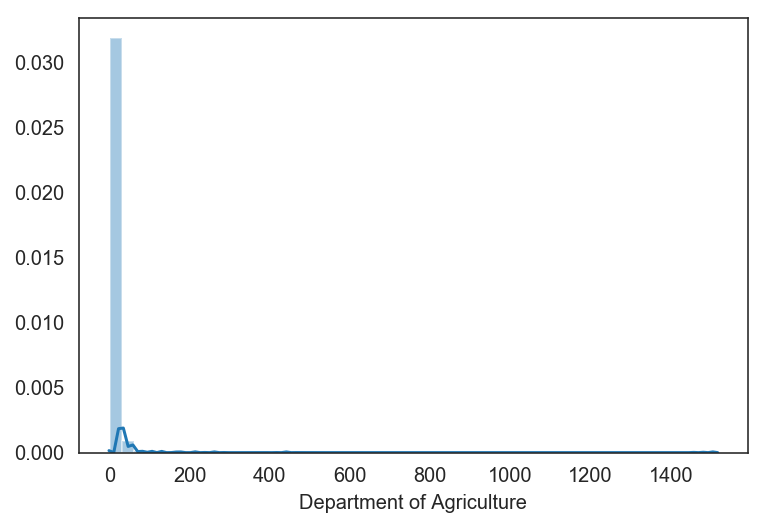

In [27]:
sns.distplot(df['Department of Agriculture'])

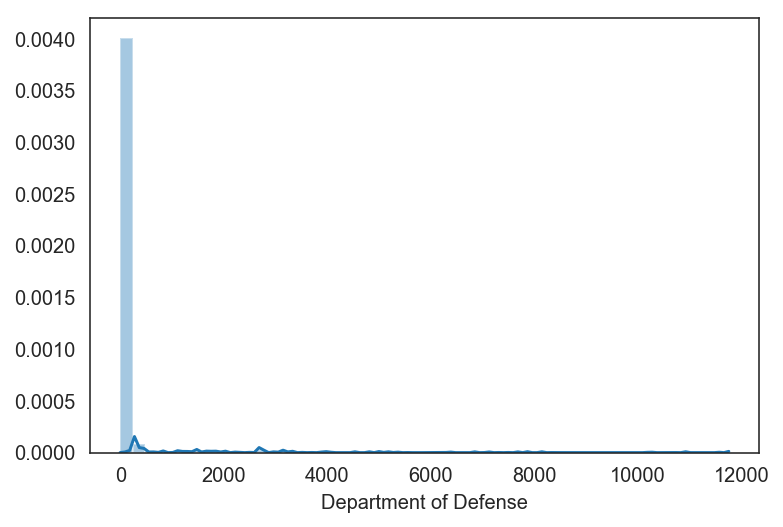

In [28]:
sns.distplot(df['Department of Defense'])

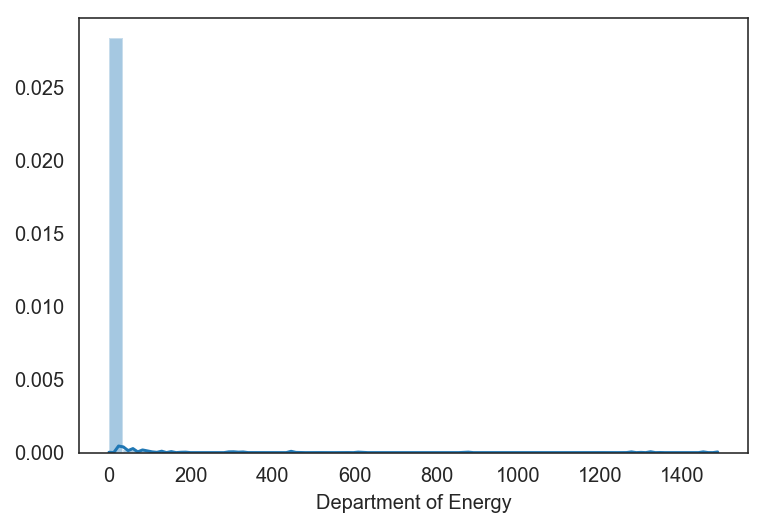

In [29]:
sns.distplot(df['Department of Energy'])

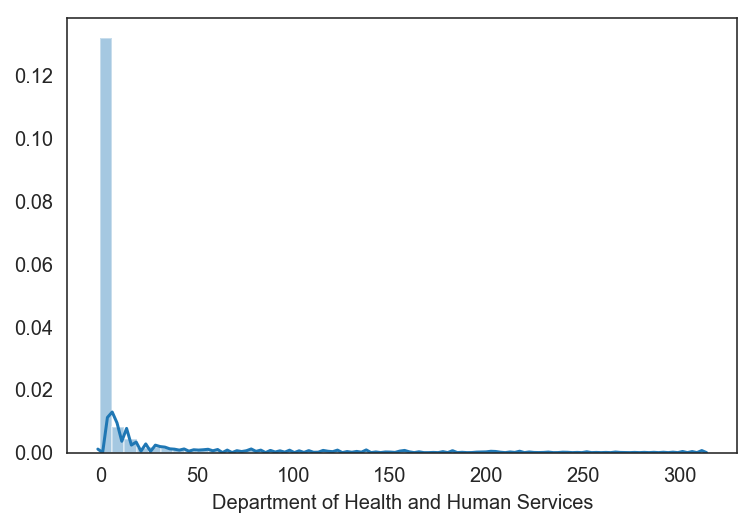

In [30]:
sns.distplot(df['Department of Health and Human Services'])

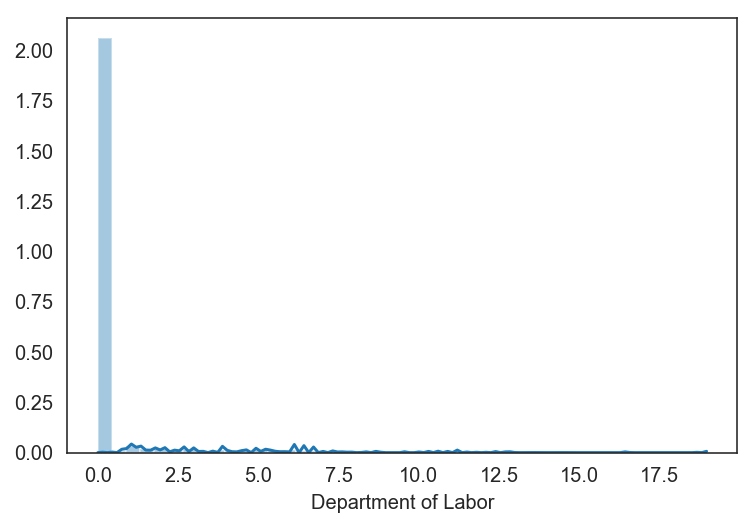

In [31]:
sns.distplot(df['Department of Labor'])

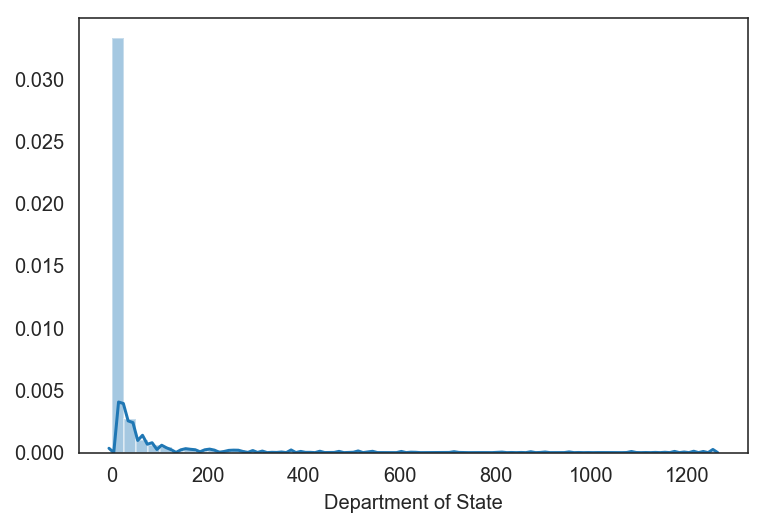

In [32]:
sns.distplot(df['Department of State'])

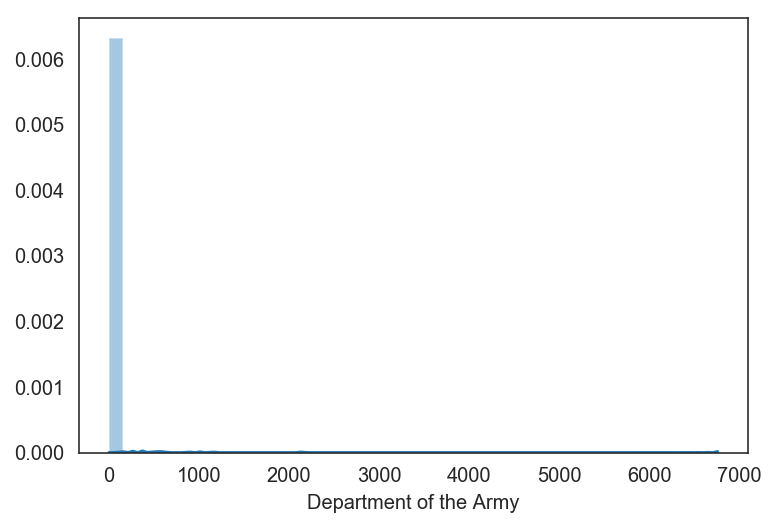

In [33]:
sns.distplot(df['Department of the Army'])

In [34]:
#sns.distplot(df['Department of the Treasury'])

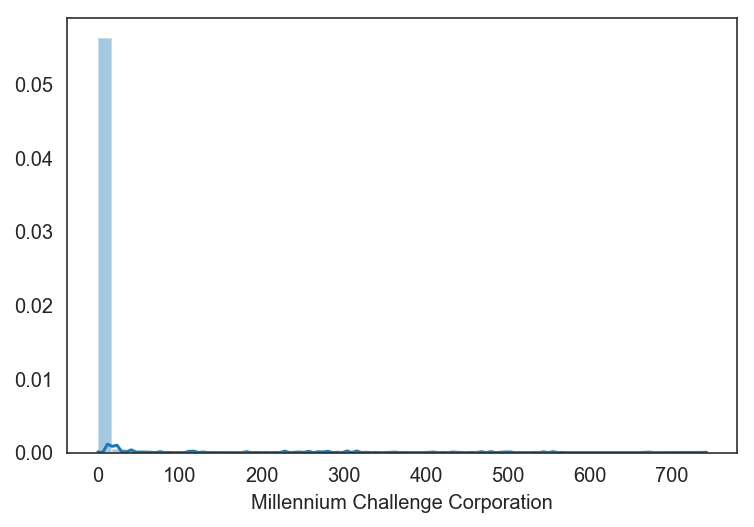

In [35]:
sns.distplot(df['Millennium Challenge Corporation'])

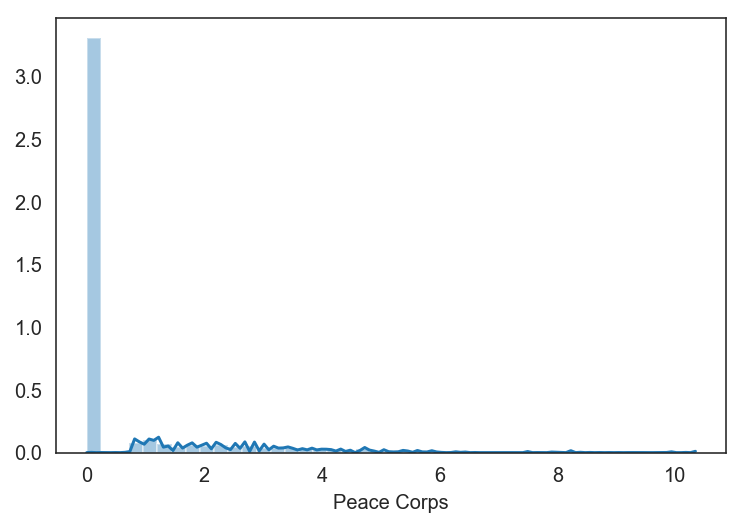

In [36]:
sns.distplot(df['Peace Corps'])

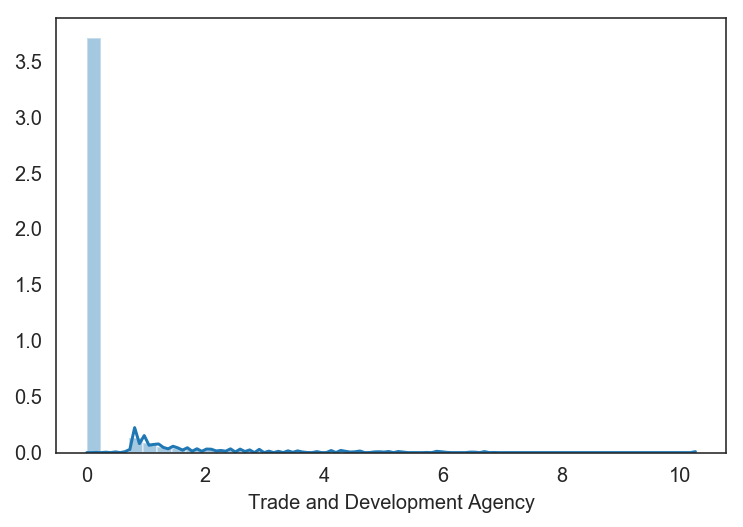

In [37]:
sns.distplot(df['Trade and Development Agency'])

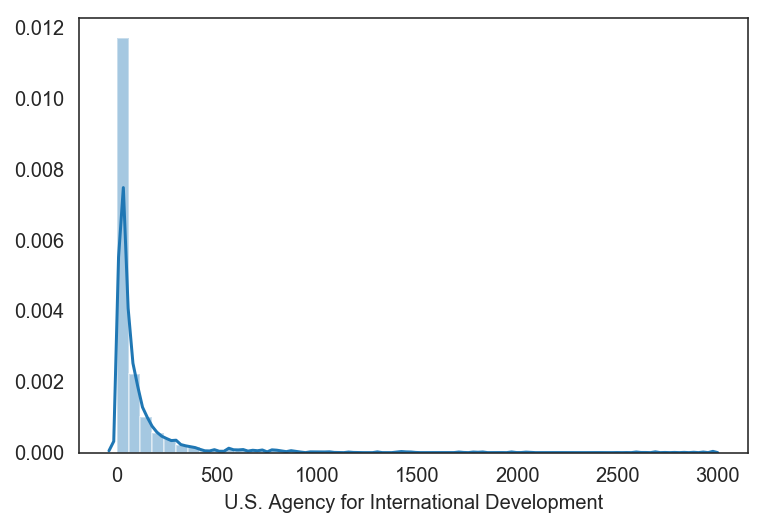

In [38]:
sns.distplot(df['U.S. Agency for International Development'])

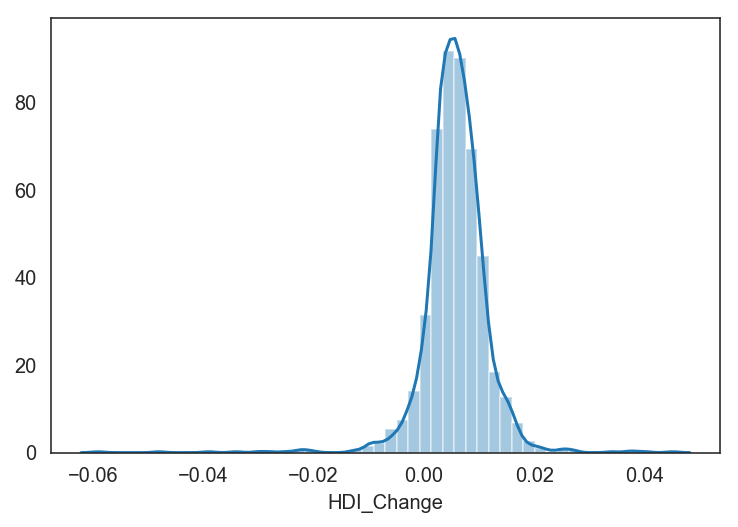

In [39]:
# Target pretty normally distributed
sns.distplot(df['HDI_Change'])

## Split data into data/target categories

In [40]:
# Define small input df (all columns except target)
X = df.loc[:, df.columns != 'HDI_Change']

# Define Targets
y = df['HDI_Change']

### Drop Columns

In [41]:
# Drop 'fiscal_year' column
X.drop(['fiscal_year'], axis=1, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Transform categorical variables

In [42]:
# Get dummy variables for 'country_name' & 'region_name', then drop original columns
X = pd.concat([X, pd.get_dummies(X[['country_name', 'region_name']])], axis=1)#'country_name', 
X.drop(['country_name', 'region_name'], axis=1, inplace=True)# 

In [43]:
# Encode Income Group Name:
# 1 = Low Income Country
# 2 = Lower Middle Income Country
# 3 = Upper Middle Income Country
# 4 = High Income Country

def rankIncomes(incomeClass):
    if incomeClass == 'Low Income Country':
        return 0
    elif incomeClass == 'Lower Middle Income Country':
        return 1
    elif incomeClass == 'Upper Middle Income Country':
        return 2
    else:
        return 3

# Apply function and drop original column
X['Country_Income_Class'] = X.income_group_name.apply(rankIncomes)
X.drop('income_group_name', axis=1, inplace=True)

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 1925
Columns: 161 entries, Agriculture to Country_Income_Class
dtypes: float64(12), int64(9), uint8(140)
memory usage: 594.4 KB


In [45]:
# List of columns
list(X.columns)

['Agriculture',
 'Commodity Assistance',
 'Economic Growth',
 'Education',
 'Governance',
 'Health and Population',
 'Humanitarian',
 'Infrastructure',
 'Department of Agriculture',
 'Department of Defense',
 'Department of Energy',
 'Department of Health and Human Services',
 'Department of Labor',
 'Department of State',
 'Department of the Army',
 'Department of the Treasury',
 'Millennium Challenge Corporation',
 'Peace Corps',
 'Trade and Development Agency',
 'U.S. Agency for International Development',
 'country_name_Afghanistan',
 'country_name_Albania',
 'country_name_Algeria',
 'country_name_Angola',
 'country_name_Argentina',
 'country_name_Armenia',
 'country_name_Azerbaijan',
 'country_name_Bahamas',
 'country_name_Bangladesh',
 'country_name_Belarus',
 'country_name_Belize',
 'country_name_Benin',
 'country_name_Bolivia',
 'country_name_Bosnia and Herzegovina',
 'country_name_Botswana',
 'country_name_Brazil',
 'country_name_Bulgaria',
 'country_name_Burkina Faso',
 'coun

In [46]:
# Look at feature collinearity 
#plt.figure(figsize=(25, 25))
#sns.set_context("paper")
#sns.heatmap(X.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
#plt.savefig('feature_correlation.png', bbox_inches = 'tight');

# Train/Val/Test Split

In [47]:
#Split the data 60 - 20 - 20 train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=42)

## Standardize Monetary Amounts

In [48]:
#After train/test split, Standardize numerical features (e.g. constant_amount)
from sklearn.preprocessing import StandardScaler

# Make copy of test and training input data
scaled_train = X_train.copy()
scaled_test = X_test.copy()

# List columns to be standardized
col_names = ['Department of Agriculture',
 'Department of Defense',
 'Department of Energy',
 'Department of Health and Human Services',
 'Department of Labor',
 'Department of State',
 'Department of the Army',
 'Millennium Challenge Corporation',
 'Peace Corps',
 'Trade and Development Agency',
 'U.S. Agency for International Development']

features_train = scaled_train[col_names]
features_test = scaled_test[col_names]

# Apply the scaler to the training set, then apply the same mean and std dev to the test set
scaler = StandardScaler()
train_amount = scaler.fit_transform(features_train)
test_amount = scaler.transform(features_test)

# Set standardized values back into original train & test sets
X_train[col_names] = train_amount
X_test[col_names] = test_amount

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

In [49]:
X_train.head()

,Agriculture,Commodity Assistance,Economic Growth,Education,Governance,Health and Population,Humanitarian,Infrastructure,Department of Agriculture,Department of Defense,...,country_name_Yemen,country_name_Zambia,country_name_Zimbabwe,region_name_East Asia and Oceania,region_name_Europe and Eurasia,region_name_Middle East and North Africa,region_name_South and Central Asia,region_name_Sub-Saharan Africa,region_name_Western Hemisphere,Country_Income_Class
1423,0,0,0,0,1,1,1,0,-0.255894,-0.179408,...,0,0,0,0,0,0,0,1,0,1
1792,0,0,0,0,1,0,1,0,-0.255894,-0.179408,...,0,0,0,0,0,0,0,0,1,2
313,0,0,1,1,1,1,1,1,-0.255894,-0.135049,...,0,0,0,0,1,0,0,0,0,1
580,1,1,1,1,1,1,0,1,-0.121086,2.075900,...,0,0,0,0,0,1,0,0,0,1
269,0,0,0,0,1,0,1,0,-0.255894,-0.173021,...,0,0,0,0,1,0,0,0,0,3


## Define RMSE

In [50]:
#Evaluate models with Root Mean Squared Error
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

## Initial OLS

In [51]:
# Create OLS model
ols_model = sm.OLS(y_train, X_train)

# Fit OLS model to training set
fit = ols_model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HDI_Change   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     2.726
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           3.69e-20
Time:                        04:16:45   Log-Likelihood:                 4463.6
No. Observations:                1155   AIC:                            -8627.
Df Residuals:                    1005   BIC:                            -7869.
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Agriculture                                   -0.0003      0.001     -0.484      0.629      -0.001       0.001
Commodity Assistance                           0.0009      0.000      1.933      0.054   -1.44e-05       0.002
Economic Growth                            -8.717e-05      0.000     -0.187      0.851      -0.001       0.001
Education                                     -0.0006      0.000     -1.259      0.208      -0.002       0.000
Governance                                     0.0005      0.001      0.637      0.524      -0.001       0.002
Health and Population                          0.0018      0.001      3.357      0.001       0.001       0.003
Humanitarian                                   0.0006      0.000      1.325      0.186      -0.000       0.002
Infrastructure                                -0.0002      0.000     -0.485      0.628      -0.001       0.001
Department of Agriculture                     -0.0002      0.000     -1.109      0.268      -0.001       0.000
Department of Defense                         -0.0003      0.000     -1.241      0.215      -0.001       0.000
Department of Energy                       -9.184e-06      0.000     -0.041      0.968      -0.000       0.000
Department of Health and Human Services        0.0001      0.000      0.435      0.664      -0.000       0.001
Department of Labor                        -9.998e-05      0.000     -0.577      0.564      -0.000       0.000
Department of State                           -0.0004      0.000     -1.438      0.151      -0.001       0.000
Department of the Army                         0.0006      0.001      1.225      0.221      -0.000       0.002
Department of the Treasury                    -0.0005      0.000     -1.880      0.060      -0.001    2.11e-05
Millennium Challenge Corporation               0.0002      0.000      1.436      0.151   -9.13e-05       0.001
Peace Corps                                   -0.0004      0.000     -1.930      0.054      -0.001    6.96e-06
Trade and Development Agency                  -0.0001      0.000     -0.537      0.591      -0.001       0.000
U.S. Agency for International Development      0.0005      0.000      1.352      0.177      -0.000       0.001
country_name_Afghanistan                       0.0036      0.003      1.385      0.166      -0.001       0.009
country_name_Albania                           0.0023      0.002      1.261      0.208      -0.001       0.006
country_name_Algeria                           0.0039      0.002      2.141      0.032       0.000       0.007
country_name_Angola                            0.0016      0.002      0.960      0.337      -0.002       0.005
country_name_Argentina                         0.0007      0.004      0.185      0.853

## LassoCV

In [52]:
# Run cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-4,4)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)

# Best alpha value:
lasso_model.alpha_

0.00014563484775012445

In [53]:
# These are the (standardized) coefficients found when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('Agriculture', 0.0),
 ('Commodity Assistance', 0.0003548238244175391),
 ('Economic Growth', 0.0),
 ('Education', -0.0),
 ('Governance', 0.0),
 ('Health and Population', 0.0004901164883111517),
 ('Humanitarian', 0.0),
 ('Infrastructure', -0.0),
 ('Department of Agriculture', -3.7372848807541276e-05),
 ('Department of Defense', 0.0),
 ('Department of Energy', -0.0),
 ('Department of Health and Human Services', 3.158945053601979e-05),
 ('Department of Labor', 0.0),
 ('Department of State', -0.00010331866186703586),
 ('Department of the Army', 0.0),
 ('Department of the Treasury', -0.0),
 ('Millennium Challenge Corporation', 9.428851511637751e-05),
 ('Peace Corps', -0.0),
 ('Trade and Development Agency', 2.3855051438094494e-05),
 ('U.S. Agency for International Development', 0.00018033061092821918),
 ('country_name_Afghanistan', 0.0),
 ('country_name_Albania', 0.0),
 ('country_name_Algeria', 0.0),
 ('country_name_Angola', 0.0),
 ('country_name_Argentina', -0.0),
 ('country_name_Armenia'

In [54]:
# Make predictions on the test set using the model
test_set_pred = lasso_model.predict(X_test)

# Evaluation:
r2_score(y_test, test_set_pred)

0.03271817535091759

In [55]:
rmse(y_test, test_set_pred)

0.006109418910080061

## RidgeCV

In [56]:
ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)

list(zip(X_train.columns, ridge_model.coef_))

[('Agriculture', -0.00013252721859335312),
 ('Commodity Assistance', 0.0010104179152055175),
 ('Economic Growth', 3.249200095549906e-05),
 ('Education', -0.0004909766652668772),
 ('Governance', 0.0005928343895892579),
 ('Health and Population', 0.001584546355189529),
 ('Humanitarian', 0.0006061927507829581),
 ('Infrastructure', -0.0004545003926598262),
 ('Department of Agriculture', -0.00024093076413811597),
 ('Department of Defense', -7.864525432316381e-05),
 ('Department of Energy', -6.778202905020726e-05),
 ('Department of Health and Human Services', 0.00014450563635381829),
 ('Department of Labor', -5.8921882770703766e-05),
 ('Department of State', -0.0003635975704202955),
 ('Department of the Army', 0.0008377136306542),
 ('Department of the Treasury', -0.0005306382961599482),
 ('Millennium Challenge Corporation', 0.00026240356159309904),
 ('Peace Corps', -0.00033736682744623997),
 ('Trade and Development Agency', -2.730930979798906e-05),
 ('U.S. Agency for International Developmen

In [57]:
# Make predictions on the test set using the model
test_set_pred = ridge_model.predict(X_test)

# Evaluation:
r2_score(y_test, test_set_pred)

0.0332024649433732

In [58]:
rmse(y_test, test_set_pred)

0.006107889315318491

## XGBoost

In [59]:
import xgboost as xgb

In [60]:
#gsc1 = GridSearchCV(estimator=xgb.XGBRegressor(), 
#                   param_grid={
#                       'max_depth': range(3,8), 
#                       'n_estimators': (10, 50, 100, 1000), 
#                       'min_child_weight': [1, 5, 10], 
#                       'gamma': [0.5, 1, 1.5, 2, 5], 
#                       'subsample': [0.6, 0.8, 1.0], 
#                       'colsample_bytree': [0.6, 0.8, 1.0]}, 
#                   scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, cv=3)

#grid_result = gsc1.fit(X_train, y_train)
#best_params = grid_result.best_params_
#gsc1.grid_scores_, gsc1.best_params_, gsc1.best_score_

In [62]:
#gsc1.best_params_

In [63]:
#{'colsample_bytree': 0.6,
# 'gamma': 0.5,
# 'max_depth': 3,
# 'min_child_weight': 1,
# 'n_estimators': 100,
# 'subsample': 0.6}

In [86]:
gbm = xgb.XGBRegressor(n_estimators=100, #arbitrary large number
                       max_depth=8,
                       objective="reg:squarederror",
                       learning_rate=0.1, 
                       subsample=0.6,
                       min_child_weight=1,
                       colsample_bytree=0.6)

#

In [87]:
eval_set=[(X_train, y_train),(X_val, y_val)] #tracking train/validation error as we go
fit_model = gbm.fit(X_train, y_train, 
                    eval_set=eval_set, 
                    eval_metric='rmse', 
                    early_stopping_rounds=20, 
                    verbose=True)


[0]	validation_0-rmse:0.445045	validation_1-rmse:0.444838
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.400609	validation_1-rmse:0.400401
[2]	validation_0-rmse:0.360614	validation_1-rmse:0.360403
[3]	validation_0-rmse:0.324588	validation_1-rmse:0.324375
[4]	validation_0-rmse:0.292164	validation_1-rmse:0.291949
[5]	validation_0-rmse:0.262978	validation_1-rmse:0.262761
[6]	validation_0-rmse:0.236747	validation_1-rmse:0.236527
[7]	validation_0-rmse:0.21311	validation_1-rmse:0.212886
[8]	validation_0-rmse:0.191843	validation_1-rmse:0.191615
[9]	validation_0-rmse:0.172693	validation_1-rmse:0.172461
[10]	validation_0-rmse:0.155476	validation_1-rmse:0.15524
[11]	validation_0-rmse:0.139976	validation_1-rmse:0.139734
[12]	validation_0-rmse:0.126004	validation_1-rmse:0.125757
[13]	validation_0-rmse:0.113439	validation_1-rmse:0.113185
[14]	validation_0-rmse:0.10

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18]	validation_0-rmse:0.067243	validation_1-rmse:0.066946
[19]	validation_0-rmse:0.060609	validation_1-rmse:0.0603
[20]	validation_0-rmse:0.054626	validation_1-rmse:0.054304
[21]	validation_0-rmse:0.049249	validation_1-rmse:0.048913
[22]	validation_0-rmse:0.044417	validation_1-rmse:0.044066
[23]	validation_0-rmse:0.040053	validation_1-rmse:0.039684
[24]	validation_0-rmse:0.036154	validation_1-rmse:0.035853
[25]	validation_0-rmse:0.032629	validation_1-rmse:0.032409
[26]	validation_0-rmse:0.0295	validation_1-rmse:0.029257
[27]	validation_0-rmse:0.026683	validation_1-rmse:0.026415
[28]	validation_0-rmse:0.024152	validation_1-rmse:0.023857
[29]	validation_0-rmse:0.021884	validation_1-rmse:0.02156
[30]	validation_0-rmse:0.01988	validation_1-rmse:0.019537
[31]	validation_0-rmse:0.018088	validation_1-rmse:0.017847
[32]	validation_0-rmse:0.0165	validation_1-rmse:0.016389
[33]	validation_0-rmse:0.015061	validation_1-rmse:0.014994
[34]	validation_0-rmse:0.013782	validation_1-rmse:0.013741
[35]	

In [88]:
fit_model_pred = fit_model.predict(X_test)

In [89]:
rmse(y_test, fit_model_pred)

0.005723237190218276

In [90]:
r2_score(y_test, fit_model_pred)

0.15113875229900142

In [91]:
list(zip(X_train.columns, fit_model.feature_importances_))

[('Agriculture', 0.0073186294),
 ('Commodity Assistance', 0.004753182),
 ('Economic Growth', 0.006636131),
 ('Education', 0.005398021),
 ('Governance', 0.0040080184),
 ('Health and Population', 0.008488631),
 ('Humanitarian', 0.005823913),
 ('Infrastructure', 0.005893361),
 ('Department of Agriculture', 0.0065897475),
 ('Department of Defense', 0.009265622),
 ('Department of Energy', 0.011146137),
 ('Department of Health and Human Services', 0.0069893445),
 ('Department of Labor', 0.004236656),
 ('Department of State', 0.010609613),
 ('Department of the Army', 0.015968276),
 ('Department of the Treasury', 0.008911732),
 ('Millennium Challenge Corporation', 0.0060318713),
 ('Peace Corps', 0.005261975),
 ('Trade and Development Agency', 0.008277255),
 ('U.S. Agency for International Development', 0.011528913),
 ('country_name_Afghanistan', 0.0),
 ('country_name_Albania', 0.0101569155),
 ('country_name_Algeria', 0.014591737),
 ('country_name_Angola', 0.008194002),
 ('country_name_Argentin

In [92]:
#feat_imp = pd.Series(fit_model.booster().get_fscore()).sort_values(ascending=False)
#feat_imp.plot(kind='bar', title='Feature Importances')
#plt.ylabel('Feature Importance Score')

In [ ]:
#To tune, we should use validation results and ignore test until 
#final verification. So here's the validation error benchmark we want to beat:
#rmse(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit),y_val) 